In [9]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
user = 'will'
if user != 'will':
    sys.path.append('../../Beltway_Project/')
    sys.path.append('../../RatterdamOpen_Project/')
    sys.path.append('../DATA/')
    sys.path.append('../../../ratterdam/')

import repetition_manuscript_defaults as MDef

import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

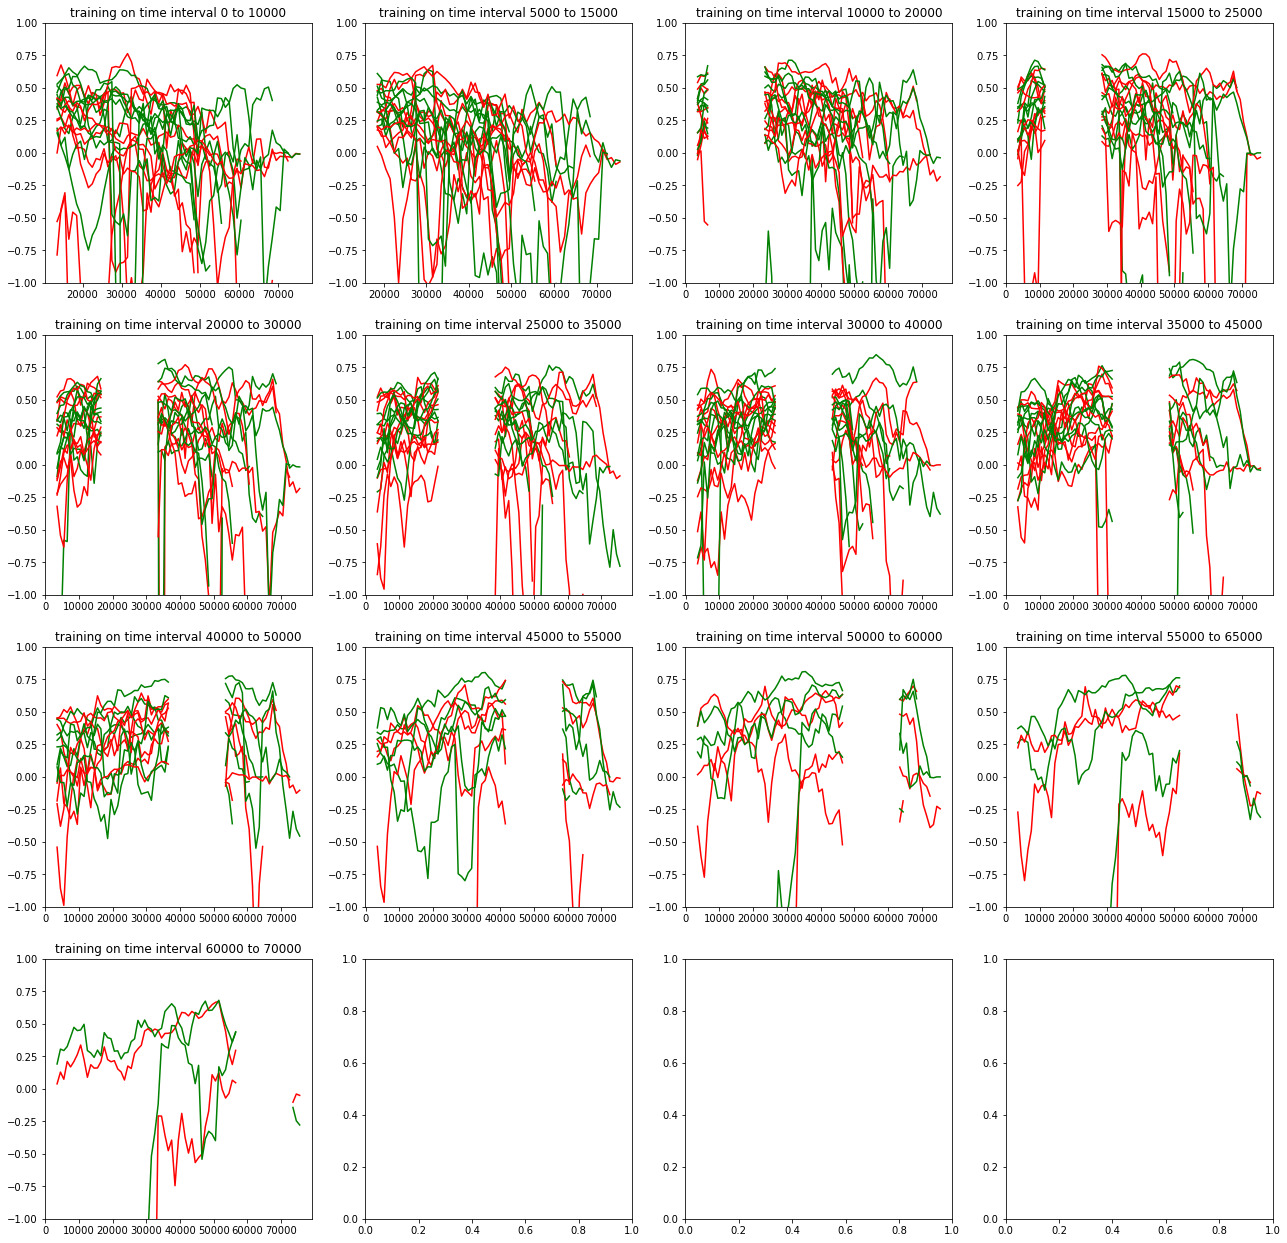

In [2]:
if user != 'will':
    file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
    alldat = pickle.load(file)
    store_dir = '../DATA/FILES/'
elif user == 'will':
    with open("E:\\Ratterdam\\R_data_repetition\\20220405-124315_superPopulationRepetition.pickle","rb") as f:
        alldat = pickle.load(f)  
    store_dir = 'E:\\Ratterdam\\repetition_manuscript\\Figure6_TemporalDynamics\\MN_analyses\\FILES\\'

fig, axs = plt.subplots(4,4,figsize=(22,22))

all_time_pos_positive = [ [] for _ in range(13) ]
all_time_pos_negative = [ [] for _ in range(13) ]
pos_corr = []
neg_corr = []
all_rats = list(alldat.keys())
for rat in all_rats:  
    all_days = list(alldat[rat].keys())
    for day in all_days:
        ##print(rat, day)
        
        inst_fr = np.load(store_dir + rat + '_' + day + '_inst_fr.npy')
        x = np.load(store_dir + rat + '_' + day + '_x_within.npy')
        y = np.load(store_dir + rat + '_' + day + '_y_within.npy')
        
        scaler = StandardScaler()
        inst_fr = scaler.fit_transform(inst_fr)

        dt = 5000##10000
        train_size = 10000##16000
        buffer = 1000
        test_size = 5000
        window = 1000

        for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
            ##print(len(inst_fr))
            ##print('starting',i*dt, i*dt+ train_size)
            all_test_scores= []
            all_test_scores_other = []

            X_train = inst_fr[i*dt: (i)*dt+ train_size]
            y_train1 = x[i*dt: (i)*dt+ train_size]
            y_train2 = y[i*dt: (i)*dt+ train_size]

            model = LinearRegression()
            model.fit(X_train, y_train1)

            model2 = LinearRegression()
            model2.fit(X_train, y_train2)

            start = (i)*dt+ train_size + buffer 
            all_mids = []
            xtest_scores = []
            ytest_scores = []
            while start + window + test_size < len(inst_fr):
                ##print(start, start + test_size)
                xscore = model.score( inst_fr[start: start + test_size],x[start: start + test_size])
                xtest_scores.append(xscore)
                yscore = model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size])
                ytest_scores.append(yscore)
                all_mids.append((start + start + test_size)/2)
                all_time_pos_negative[i].append(np.array([(start + start + test_size)/2, xscore]))
                start = start + window
            
            if len(all_mids)>5:
                neg_corr.append(scipy.stats.spearmanr(all_mids, xtest_scores)[0])
                ##neg_corr.append(scipy.stats.spearmanr(all_mids, np.maximum(xtest_scores,0))[0])


            all_mids_other = []
            start = (i)*dt- buffer-test_size 

            xtest_scores_other = []
            ytest_scores_other = []
            while start >0:
                ##print('early', start, start+test_size)
                xscore = model.score(inst_fr[start: start + test_size],x[start: start + test_size])
                xtest_scores_other.append(xscore)
                yscore = model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size])
                ytest_scores_other.append(yscore)
                all_mids_other.append((start + start + test_size)/2)
                all_time_pos_positive[i].append(np.array([(start + start + test_size)/2, xscore]))
                start = start - window
            if len(all_mids_other)>5:
                pos_corr.append(scipy.stats.spearmanr(all_mids_other, xtest_scores_other)[0])
                ##pos_corr.append(scipy.stats.spearmanr(all_mids_other, np.maximum(xtest_scores_other,0))[0])
                
            axs[int(np.floor(i/4)),i%4].plot(all_mids, xtest_scores, color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_mids, ytest_scores, color = 'green')
            axs[int(np.floor(i/4)),i%4].plot(all_mids_other, xtest_scores_other,color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_mids_other, ytest_scores_other,color = 'green')
            axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
            axs[int(np.floor(i/4)),i%4].set_title('training on time interval '+ str(i*dt)+ ' to ' + str(i*dt + train_size))




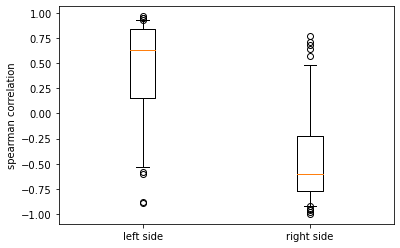

In [3]:
## plotting

##pos_corr= np.nan_to_num(pos_corr, 0)
##neg_corr = np.nan_to_num(neg_corr, 0)

fig, ax = plt.subplots()
ax.boxplot([pos_corr, neg_corr], whis = [5,95])
ax.set_xticklabels(['left side', 'right side'])
ax.set_ylabel('spearman correlation')
plt.show()

## add scatter

In [19]:
## statistics
## are the two correlations different?
print(scipy.stats.mannwhitneyu(pos_corr, neg_corr))
print(scipy.stats.ttest_ind(pos_corr, neg_corr))

## is the left side correlation greater than 0?
print(scipy.stats.ttest_1samp(pos_corr, 0, alternative='greater'))
## we can reject the null
## conclude left side correlation is positive 

## is the population correlation left less than 0?
print(scipy.stats.ttest_1samp(neg_corr, 0, alternative='less'))
## we can reject the null
## conclude right side correlation is negative

MannwhitneyuResult(statistic=632.0, pvalue=2.0000469810754637e-18)
Ttest_indResult(statistic=12.347263819999856, pvalue=6.020154240137431e-25)
Ttest_1sampResult(statistic=7.593532875863802, pvalue=5.1127690241788544e-11)
Ttest_1sampResult(statistic=-10.03274909867034, pvalue=1.539755677674772e-16)


In [13]:
%matplotlib qt5
df_corr = pd.DataFrame(np.array([np.array(pos_corr), np.array(['left']*len(pos_corr))]).T, columns = ['correlation', 'left-right'])
df_corr_2 = pd.DataFrame(np.array([np.array(neg_corr), np.array(['right']*len(neg_corr))]).T, columns = ['correlation', 'left-right'])
df_corr = df_corr.append(df_corr_2, ignore_index = True)
df_corr["correlation"] = pd.to_numeric(df_corr["correlation"])
##sb.stripplot(x = 'left-right', y = 'correlation', data = df_corr)
##sb.boxplot(x = 'left-right', y = 'correlation', data = df_corr)
fig, ax = plt.subplots()
v = ax.violinplot([df_corr[df_corr['left-right']=='left'].correlation,
                   df_corr[df_corr['left-right']=='right'].correlation
                    ],  
              positions=range(2),
              )
for vpart in v['bodies']:
    vpart.set_facecolor('darkgrey')
    vpart.set_edgecolor('black')
    vpart.set_linewidth(1),
    vpart.set_alpha(0.8)
    
for el in ['cbars','cmaxes','cmins']:
    v[el].set_color('black')
               
ax.set_xticks(range(2))
ax.set_xticklabels(['Before Training Window', 'After Training Window'],rotation=0,fontsize=MDef.ticksize)
ax.tick_params(axis='both', which='major', labelsize=MDef.ticksize)
ax.set_ylabel("Spearman Correlation of Decoding Performance",fontsize=MDef.ylabelsize)  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 


In [6]:
df_corr

,correlation,left-right
0,-0.533333,left
1,-0.134066,left
2,0.507018,left
3,0.011304,left
4,0.456158,left
...,...,...
155,0.483426,right
156,0.256923,right
157,-0.118797,right
158,-0.517857,right


In [26]:
df_corr[df_corr['left-right']=='left'].correlation.std()

0.4887873770409778